<a href="https://colab.research.google.com/github/Alxjgr/Coursera-projet-network/blob/main/Retrieval_Augmented_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Retrieval Augmented Generation with Langchain***

This notebook demonstrates how to build a Retrieval-Augmented Generation (RAG) system using LangChain, a powerful framework for creating applications with large language models (LLMs). RAG combines information retrieval techniques with generative AI to provide accurate and context-aware responses by grounding outputs on retrieved data.

**Indexing**

1. Load:  
In this step, I load the content of the selected website as my information source. I use a tool to extract only the relevant sections, such as the post content, titles, and headers. This allows me to focus on the information that is directly related to the topic, ignoring irrelevant parts of the web page. This step is essential for ensuring that the data I work with is clean and focused on the core content.


2. Split:  
After loading the data, the next step is to split the content into smaller, manageable chunks. The reason for splitting the text is that large documents are difficult to search through efficiently, and they may exceed the model's context window. By breaking the text into smaller sections, I make it easier to retrieve relevant pieces of information when needed. This process ensures that each chunk is small enough for effective processing but still contains enough context to be meaningful.
3. Store :  
Once the data is split into smaller chunks, I need to store and index these chunks to facilitate efficient searching later. For this, I use a vector store, which stores the document chunks in a way that makes it easy to search for relevant text based on semantic similarity. By adding the chunks to the vector store, I ensure that the information is structured and ready for quick retrieval when a user asks a question.

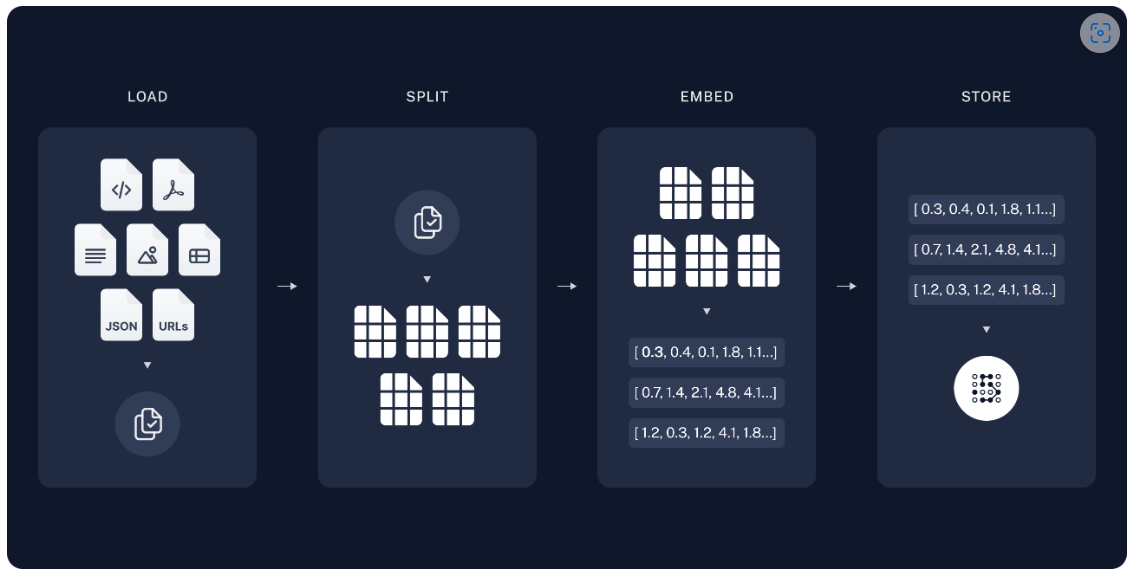

**Retrival and generation**

Retrive :  
In this part, I define the workflow for retrieving relevant information and generating the answer to a user’s query. The first step is the retrieve function, where I search the vector store for document chunks that are most relevant to the user’s question. This search is based on semantic similarity, meaning I retrieve chunks that are contextually related to the question, even if they don't exactly match the query text.

Generate :   
Once the relevant chunks are retrieved, the generate function comes into play. Here, I take the retrieved document chunks and pass them, along with the user’s question, to the language model. The model generates an answer based on the question and the context provided by the retrieved documents. This combination of retrieval and generation allows the system to provide accurate and contextually relevant answers.

   


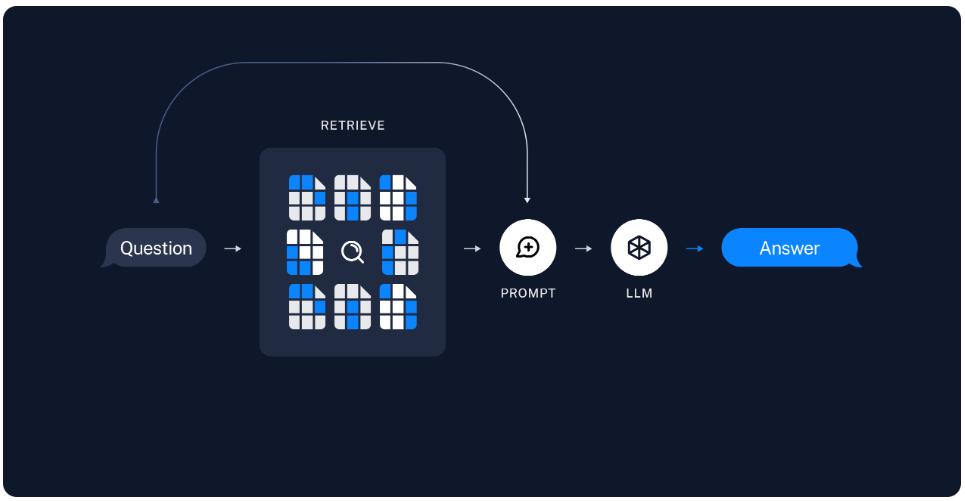

In [ ]:
%pip install --quiet --upgrade langchain-text-splitters langchain-community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 1.6 MB/s eta 0:00:00


In [ ]:
import getpass
import os

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass()

··········


### chat model
In this part, we install the necessary package for Mistral AI and set up the environment for interacting with Mistral's large language model (LLM). The model is initialized to generate responses based on user input, enabling chat-based interactions.

In [ ]:
pip install -qU langchain-mistralai

In [ ]:
import getpass
import os

os.environ["MISTRAL_API_KEY"] = getpass.getpass()

from langchain_mistralai import ChatMistralAI

llm = ChatMistralAI(model="mistral-large-latest")

··········


### embedding model
Here, we install and configure MistralAI for generating embeddings of text data. These embeddings are used to represent text in a numerical format, allowing us to perform efficient similarity searches on large datasets to find relevant content.




In [ ]:
pip install -qU langchain-mistralai

In [ ]:
import getpass

os.environ["MISTRALAI_API_KEY"] = getpass.getpass()

from langchain_mistralai import MistralAIEmbeddings

embeddings = MistralAIEmbeddings(model="mistral-embed")

··········


/usr/local/lib/python3.10/dist-packages/langchain_mistralai/embeddings.py:175: UserWarning: Could not download mistral tokenizer from Huggingface for calculating batch sizes. Set a Huggingface token via the HF_TOKEN environment variable to download the real tokenizer. Falling back to a dummy tokenizer that uses `len()`.
  warnings.warn(


### vector store
This section sets up an in-memory vector store to store the generated embeddings. The vector store acts as a repository where the embeddings are indexed and can later be queried for similarity to a given user query, enabling retrieval of relevant documents.

In [ ]:
pip install -qU langchain-core

In [ ]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

# Preview
In this part, we load the content of a web page, process the text into smaller chunks, and index it in the vector store. We then define the application workflow to retrieve relevant content and generate an answer to the user's query using the previously loaded data and the defined models. This completes the setup for a retrieval-augmented generation (RAG) pipeline.

In [ ]:
!pip install langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 6.1 MB/s eta 0:00:00


In [ ]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

# Index chunks
_ = vector_store.add_documents(documents=all_splits)

# Define prompt for question-answering
prompt = hub.pull("rlm/rag-prompt")


# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


# Define application steps
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

In [ ]:
response = graph.invoke({"question": "What is Task Decomposition?"})
print(response["answer"])

Task Decomposition is a strategy where a complex task is broken down into smaller, simpler steps. This is often done by instructing a model to "think step by step," which helps enhance its performance on complex tasks. It can be achieved through simple prompting, task-specific instructions, or human inputs.


# Detailed walkthrough

##  **1. Indexing**

###Loading documents
This section loads a specific web page (Lilian Weng's blog post) using WebBaseLoader from the langchain library. We use BeautifulSoup to extract only the title, headers, and content of the blog post. The SoupStrainer is used to filter the HTML content to retain the relevant sections for indexing.



In [ ]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

# Only keep post title, headers, and content from the full HTML.
bs4_strainer = bs4.SoupStrainer(class_=("post-title", "post-header", "post-content"))
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs={"parse_only": bs4_strainer},
)
docs = loader.load()

assert len(docs) == 1
print(f"Total characters: {len(docs[0].page_content)}")

Total characters: 43131


In [ ]:
print(docs[0].page_content[:500])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In


### Splitting documents
Once the document is loaded, we split the content into smaller chunks using RecursiveCharacterTextSplitter. This step is necessary because large documents are harder to process and analyze by models due to context window limitations. We define a chunk size of 1000 characters and an overlap of 200 characters between chunks, ensuring that the chunks are manageable while retaining context between them.

In [ ]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 66 sub-documents.


## Storing documents
After splitting the document into smaller chunks, we store the chunks in a vector store (which is a memory-efficient data structure for storing vectorized data) using the add_documents method. This step indexes the document so that it can later be searched for relevant information based on similarity to a user query.

In [ ]:
document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:3])

['ed41fb73-a6da-408d-8ee0-2c2a2facd0cf', 'fbb6b692-eb79-42a6-b4f9-65ae11eec51a', 'f32335cc-b3f9-4a47-b8ca-98a8b4f062db']


### Retrieval and Generation
In the Retrieval and Generation section, we first define a prompt using the hub.pull() method to generate context-based responses. This prompt is used to guide the LLM in producing answers based on the relevant document context. We then set up the application state with a State class that tracks the user’s question, the context (relevant document chunks), and the generated answer. Two main functions are defined: retrieve, which uses the vector store to search for the most relevant document chunks based on the question, and generate, which uses the retrieved context to generate an answer via the LLM. The control flow is managed using StateGraph, where the steps are executed sequentially — first retrieving the relevant documents and then generating the answer. The process is visualized with a flow diagram to better understand the connections between steps. Once the setup is complete, we test the system by invoking it with a sample question, "What is Task Decomposition?" and printing both the retrieved context and the model-generated answer. Additionally, we explore the streaming functionality to display real-time updates or messages during the execution, providing a dynamic and interactive user experience.

In [ ]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


In [ ]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict

# State
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

# Nodes
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

# Control flow
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

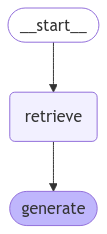

In [ ]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
result = graph.invoke({"question": "What is Task Decomposition?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='f32335cc-b3f9-4a47-b8ca-98a8b4f062db', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1585}, page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.'), Document(id='6215ab12-2cd9-4d08-9aec-9389d1ea2859', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent

In [ ]:
for step in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

{'retrieve': {'context': [Document(id='f32335cc-b3f9-4a47-b8ca-98a8b4f062db', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1585}, page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.'), Document(id='6215ab12-2cd9-4d08-9aec-9389d1ea2859', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Fig. 1. Overview of a LLM-powered autonomous agent sy

In [ ]:
for message, metadata in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="messages"
):
    print(message.content, end="|")

|Task| De|com|position| is| a| technique| used| to| break| down| complex| tasks| into| smaller|,| more| manage|able| steps|.| This| is| often| achieved| through| the| "|Chain| of| Thought|"| (|Co|T|)| prompt|ing| technique|,| where| a| model| is| instruct|ed| to| "|think| step| by| step|."| This| approach| not| only| enh|ances| performance| on| complex| tasks| but| also| provides| insight| into| the| model|'|s| thinking| process|.||

In [ ]:
from langchain_core.prompts import PromptTemplate

template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible.
Always say "thanks for asking!" at the end of the answer.

{context}

Question: {question}

Helpful Answer:"""
custom_rag_prompt = PromptTemplate.from_template(template)

# Query analysis
In this section, we first determine the total number of document splits (total_documents) and divide them into three equal parts, labeled as "beginning," "middle," and "end." We then loop through each document and assign metadata based on which section of the document it belongs to, ensuring that each chunk has clear context about its position in the original document. This metadata helps in later filtering when searching for relevant information based on the user's query. The section metadata is stored within the all_splits documents, and the first document’s metadata is printed as a check.

Next, we set up an in-memory vector store using the embeddings, which allows us to index the document chunks and later retrieve them based on similarity to a query. These indexed documents are then added to the vector store, enabling efficient retrieval during the search process.

We then define the Search class, which structures the query data with a field for the search query itself and the section to query ("beginning," "middle," or "end"). The State class is also extended to track the user's question, the structured query, the retrieved context, and the generated answer.

The analyze_query function is responsible for analyzing the user's question using a structured LLM model to generate a query with appropriate section metadata. Once the query is structured, the retrieve function searches the vector store for relevant documents based on both the query and section filters. The generate function processes the retrieved documents and generates an answer by passing the context to the LLM.

Finally, the application flow is orchestrated using StateGraph, where the sequence starts with the query analysis, followed by retrieval and answer generation. The process is visualized through a flow diagram, which is rendered using graph.get_graph().draw_mermaid_png() to better understand the application's flow. The system is then tested with a query about "Task Decomposition" at the "end" of the document, and real-time updates are printed to show the query’s processing steps.

In [ ]:
total_documents = len(all_splits)
third = total_documents // 3

for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"


all_splits[0].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'start_index': 8,
 'section': 'beginning'}

In [ ]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)
_ = vector_store.add_documents(all_splits)

In [ ]:
from typing import Literal

from typing_extensions import Annotated


class Search(TypedDict):
    """Search query."""

    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["beginning", "middle", "end"],
        ...,
        "Section to query.",
    ]

In [ ]:
class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str


def analyze_query(state: State):
    structured_llm = llm.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    return {"query": query}


def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query["query"],
        filter=lambda doc: doc.metadata.get("section") == query["section"],
    )
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()

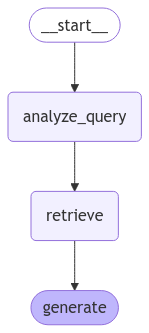

In [ ]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
for step in graph.stream(
    {"question": "What does the end of the post say about Task Decomposition?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': {'query': 'Task Decomposition', 'section': 'end'}}}

----------------



{'retrieve': {'context': [Document(id='2806b5d0-ad88-47ca-80bc-f92e0d70c704', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 30952, 'section': 'end'}, page_content='Here are a sample conversation for task clarification sent to OpenAI ChatCompletion endpoint used by GPT-Engineer. The user inputs are wrapped in {{user input text}}.\n[\n  {\n    "role": "system",\n    "content": "You will read instructions and not carry them out, only seek to clarify them.\\nSpecifically you will first summarise a list of super short bullets of areas that need clarification.\\nThen you will pick one clarifying question, and wait for an answer from the user.\\n"\n  },\n  {\n    "role": "user",\n    "content": "We are writing {{a Super Mario game in python. MVC components split in separate files. Keyboard control.}}\\n"\n  },\n  {\n    "role": "assistant",'), Document(id='b62178f2-5451-41ce-886d-fc3a02dd4ea1', metadata={'source': 'https://lilianweng.github.io/post

# **Part 2**

### Dependencies

In [ ]:
%%capture --no-stderr
%pip install --upgrade --quiet langgraph langchain-community beautifulsoup4

### LangSmith

In [ ]:
os.environ["LANGCHAIN_TRACING_V2"] = "true"
if not os.environ.get("LANGCHAIN_API_KEY"):
    os.environ["LANGCHAIN_API_KEY"] = getpass.getpass()

### Chains and Retrieval Process
In this section, the process begins by loading and splitting the blog content into smaller chunks, making it more manageable for subsequent querying. The content is loaded using WebBaseLoader, which pulls the necessary sections (content, title, and headers) from the provided webpage. Then, RecursiveCharacterTextSplitter divides the content into smaller sub-documents, each containing a maximum of 1000 characters with an overlap of 200 characters to preserve context.

Once the content is split into chunks, these documents are indexed in the vector_store, making them searchable. The retrieval process is powered by a tool function (retrieve) which performs a similarity search in the vector store, finding the most relevant documents related to the query.

The workflow then progresses with the use of LangGraph's StateGraph. This system orchestrates a flow where it first processes the input query using a tool call to fetch relevant information and then generates a response based on the retrieved content. The response is carefully structured to ensure that the answer is both concise and contextually accurate. The system ensures a streamlined flow by combining AI model queries with retrieved data to provide a meaningful and accurate response.

Thus, this part of the code enables document indexing, querying, and generating context-aware answers through an automated, multi-step process, utilizing retrieval tools and AI models for intelligent response generation.

In [ ]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from typing_extensions import List, TypedDict

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

In [ ]:
# Index chunks
_ = vector_store.add_documents(documents=all_splits)


In [ ]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

In [ ]:
from langchain_core.tools import tool


@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

In [ ]:
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode


# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}


# Step 2: Execute the retrieval.
tools = ToolNode([retrieve])


# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}

In [ ]:
from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

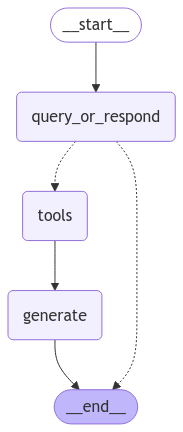

In [ ]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
input_message = "Hello"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Hello


================================== Ai Message ==================================

Hello! How can I assist you today?


In [ ]:
input_message = "What is Task Decomposition?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is Task Decomposition?
================================== Ai Message ==================================

Task decomposition is the process of breaking down a complex task or project into smaller, more manageable subtasks or steps. This approach helps in understanding, planning, and executing the task more effectively. Here are some key aspects of task decomposition:

1. **Breaking Down Complexity**: By dividing a large task into smaller parts, each component becomes simpler to understand and handle.

2. **Improved Planning**: Decomposing tasks allows for better planning and resource allocation. Each subtask can be scheduled, and resources can be assigned more efficiently.

3. **Enhanced Focus**: Smaller tasks enable individuals or teams to focus on specific parts of the project, leading to better quality and productivity.

4. **Better Tracking**: Progress can be more easily tracked and measured when 

## Stateful management of chat history
In this section, the system utilizes MemorySaver from LangGraph to maintain stateful management of the chat history across multiple interactions. By integrating memory functionality into the flow, it allows the system to "remember" prior messages, preserving the context for future queries. The graph_builder.compile(checkpointer=memory) method is used to ensure that each interaction with the chat flow is saved into memory, and this memory is referenced when further steps or queries are made.

A unique thread_id is specified in the configuration to maintain a consistent conversation thread, allowing the system to manage different conversations separately. The chat process is then initiated by sending user messages (such as "What is Task Decomposition?"), and the system streams the responses, ensuring that each message in the sequence is appropriately handled and printed in the correct format.

In [ ]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

# Specify an ID for the thread
config = {"configurable": {"thread_id": "abc123"}}

In [ ]:
input_message = "What is Task Decomposition?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is Task Decomposition?


================================== Ai Message ==================================

Task decomposition is the process of breaking down a complex task or project into smaller, more manageable sub-tasks or components. This approach helps in understanding, planning, and executing large and intricate tasks more effectively. Here are some key aspects of task decomposition:

1. **Hierarchical Breakdown**: The task is divided into levels, with each level containing sub-tasks that are smaller and more specific than the previous level.

2. **Clarity and Focus**: By breaking down a task, each sub-task can be clearly defined, making it easier to focus on specific aspects without getting overwhelmed by the complexity of the whole task.

3. **Efficient Resource Allocation**: Smaller tasks can be assigned to different team members or resources, enabling parallel work and better utilization of resources.

4. **Improved Management**: Decomposing tasks allows for better project management, including more

In [ ]:
input_message = "Can you look up some common ways of doing it?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Can you look up some common ways of doing it?


================================== Ai Message ==================================
Tool Calls:
  retrieve (s9jhjbiue)
 Call ID: s9jhjbiue
  Args:
    query: common ways of task decomposition


================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Fig. 1. Overview of a LLM-powered autonomous agent system.
Component One: Planning#
A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.
Task Decomposition#
Chain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1585, 'section': 'beginning'}
Content: Fig. 1. Overview of a LLM-powered autonomous agent system.
Component One: Planning

## Agents
In this part, LangGraph's create_react_agent is used to build an agent that can interact with the system dynamically. The agent is able to retrieve information using the retrieve tool and execute the necessary steps to generate responses based on user queries. The integration of memory with the agent allows it to continue a conversation over time, remembering past interactions and adapting to new queries.

The agent is executed by streaming user inputs, such as "What is the standard method for Task Decomposition?", and then looking up additional relevant information once an answer has been retrieved. The memory integration ensures that each message and its context are preserved, making the interaction feel coherent and connected over the course of the conversation. The visual representation of the agent's flow is displayed using a mermaid diagram, which allows for easy visualization of the agent's decision-making process.

Thus, this section demonstrates how the system handles dynamic interactions, manages chat history, and facilitates more advanced agent-driven conversations while retaining context across multiple exchanges.

In [ ]:
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(llm, [retrieve], checkpointer=memory)

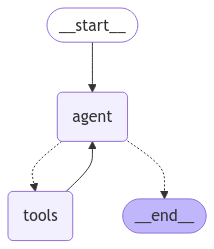

In [ ]:
display(Image(agent_executor.get_graph().draw_mermaid_png()))

In [ ]:
config = {"configurable": {"thread_id": "def234"}}

input_message = (
    "What is the standard method for Task Decomposition?\n\n"
    "Once you get the answer, look up common extensions of that method."
)

for event in agent_executor.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the standard method for Task Decomposition?

Once you get the answer, look up common extensions of that method.
================================== Ai Message ==================================
Tool Calls:
  retrieve (CZNSTjCTy)
 Call ID: CZNSTjCTy
  Args:
    query: standard method for Task Decomposition


================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1585, 'section': 'beginning'}
Content: Fig. 1. Overview of a LLM-powered autonomous agent system.
Component One: Planning#
A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.
Task Decomposition#
Chain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Fig. 1. Overview of a LLM-powered autonomous agent system.
Component One: Planning